## Formalism

What is Monte Carlo integration (super helpful reference: https://cs.dartmouth.edu/wjarosz/publications/dissertation/appendixA.pdf):

$\int{f(x)dx} = ???$

Introduce x ~ $p$, where $p$ is a "pdf" function, like a normal distribution for example:

$\langle \frac{f}{p} \rangle_{p} = \int{\frac{f(x)}{p(x)} p(x) dx} = \int{f(x)dx}$

So if we can take a large sample x ~ $p$ of size N, then:

$y(x) \equiv \frac{f(x)}{p(x)}$

$\bar{y} \equiv \frac{1}{N}\sum{y} \approx \int{f(x)dx}$

$\sigma(\bar{y})^2 = \frac{1}{N}\sigma(y)^2$

We can make numerically fast, unbiased, and Gaussian estimates of bizarre integrals!

What if we want to minimize the error in our estimate? If we could find some magic $p$ such that $Ap = f$, where A is some constant, then:

$\sigma(\bar{y})^2 = \frac{1}{N}\sigma(y)^2 = \frac{1}{N}\sigma(A) = 0$

So (in general) we want to find a distribution $p$ that has *as close to the same shape as possible* as our test function.

Note: there many not be a computationally tractable $p$ that fits this criteria "perfectly." Even if there were, we would therefore know $A$ and our integral...no need for all this fancy stuff!


## Basic Example

First import some modules from this package:

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import sys
import pathlib

# repo data folder for loading
# TODO: this is basically a proxy for a full installation
fpath = pathlib.Path.cwd().parent / 'data'
mpath = pathlib.Path.cwd().parent / 'modules'
sys.path.append(str(mpath))

import monte_carlo as mc
from beam import Beam
from detector import ColdLoad, Pixel, FilterStack

pi = np.pi

Let's try integrating a test function:

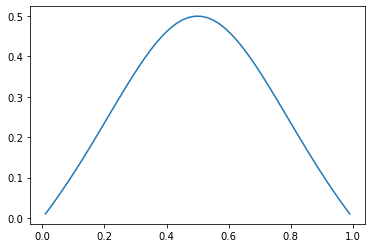

In [2]:
def f(x):
    return 1/(1+(2*x - 1)**2) - 0.5

min = 0.01
max = 0.99

x = np.linspace(min, max)
plt.plot(x,f(x))

For this example, we will use a "beta" distribution with parameters $a = b = 2.531$:

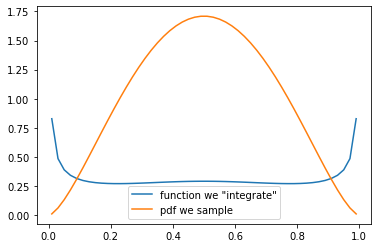

In [3]:
def pdf(x, a, b):
    return stats.beta.pdf(x, a, b)

magic_a = 2.531
magic_b = 2.531
y = f(x) / pdf(x, magic_a, magic_b)

plt.plot(x, y, label = 'function we "integrate"')
plt.plot(x, pdf(x, magic_a, magic_b), label = 'pdf we sample')
plt.legend()

Now (*very important*) we need to sample from this exact same distribution before taking our average:

In [8]:
x2 = stats.beta.rvs(magic_a, magic_b, size = 10)
y2 = f(x2) / pdf(x2, magic_a, magic_b)

est, err = mc.mc_integrate(y2)

true = 0.285398
print(f'we got {est}')
print(f'the actual error was {np.abs(est - true)}')
print(f'the estimated error was {err}')

we got [0.28617017]
the actual error was [0.00077217]
the estimated error was [0.00202251]


What about a test integral in spherical coordinates, something that looks like our beam? We'll integrate this:

$ f(x) \equiv cos(x)$

$\int_0^{\pi/4}{d\theta \int_0^{.375 * 2\pi}{d\phi f(\theta)sin(\theta)}}$

We use a "beta-uniform distribution":

$pdf(x) = w * beta_{pdf}(x, a, b) + (1-w)*uniform_{pdf}(x, 0, \pi/2)$

And perform the integral:

In [11]:
def test_integral(f = np.cos, max_theta = pi/4, slice_frac = 3/8, size = int(4e5), jacobian = np.sin):
    # get fit params
    x_fit = np.linspace(0, pi/2)
    y_fit = f(x_fit) * jacobian(x_fit)
    mc_dist = mc.beta_uniform()
    params, _ = mc_dist.fit_params(x_fit, y_fit)

    # get theta samples
    params = params[1:]
    theta = mc_dist.rvs(*params, size = size)

    # get phi samples
    phi = 2*pi * np.random.rand(size)

    # get mask
    mask = np.logical_or(theta > max_theta, phi/2/pi > slice_frac)

    # get integral
    y = 2*pi * f(theta) * jacobian(theta) / mc_dist.pdf(theta, *params)
    est, err = mc.mc_integrate(y, mask = mask)
    return est, err

est, err = test_integral()

true = 2*pi*3/8 * 0.25
print(f'we got {est}')
print(f'the actual error was {np.abs(est - true)}')
print(f'the estimated error was {err}')

we got [0.59053441]
the actual error was [0.00148579]
the estimated error was [0.00191263]


## Detectors!

We want to perform this integral (see Choi et. al. 2017 https://arxiv.org/pdf/1711.04841.pdf):

$P_d(T) = \int{d\nu \int{d\Omega \epsilon(\nu)f(\nu)A_d*B(\nu, T)P(\nu, \Omega)}}$

$P_d(T) = 0.5 * \int{d\nu \epsilon(\nu)f(\nu)\frac{c^2}{\nu^2}B(\nu, T) \frac{\int_{d,cl}{d\Omega P(\Omega, \nu)}}{ \int{d\Omega P(\Omega, \nu)}}}$

$P_d(T) = 0.5 * \int{d\nu \epsilon(\nu)f(\nu)\frac{c^2}{\nu^2}B(\nu, T) \frac{\Omega_{d,cl}(v)}{\Omega(v)}}$

Separate out the angular parts:

$\Omega_{d,cl}(v) \equiv \int_{cl}{d\phi d\theta sin(\theta) P(\theta)}$

$\Omega(v) \equiv \int{d\phi d\theta sin(\theta) P(\theta)}$

First initialize Beam, Cold Load, and Filters objects. The beam will store all the $\Omega(v)$ values:

In [5]:
b = Beam('MF_F')
cl = ColdLoad('20200912')
f = Filters('20200912')

loading beam file
fitting sin-convolved beam fit params
getting sin-weighted-pdf theta samples
evaluating sin-convolved beam solid angles as a function of freq


NameError: name 'Filters' is not defined

We show the beam and its fitted pdf:

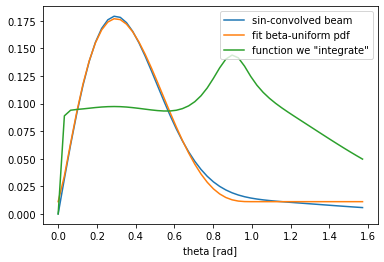

In [13]:
x = np.linspace(0, pi/2)
g = b.beams['90'](x) * np.sin(x)
plt.plot(x, g, label = 'sin-convolved beam')

params = b.beam_fit_params['90']
plt.plot(x, b.mc_dist.f(x, *params), label = 'fit beta-uniform pdf')
plt.plot(x, g / b.mc_dist.pdf(x, *params[1:]), label = 'function we "integrate"')

plt.xlabel('theta [rad]')
plt.legend()

Next, the beam solid angle $\Omega(v)$ and its error:

Text(0, 0.5, 'solid angle [str]')

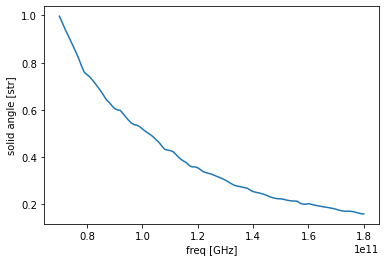

In [14]:
plt.plot(b.freqs, b.sas)
plt.xlabel('freq [GHz]')
plt.ylabel('solid angle [str]')

Text(0, 0.5, 'error(solid angle) [%]')

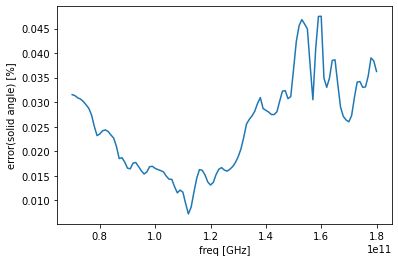

In [15]:
plt.plot(b.freqs, b.sas_err/b.sas*100)
plt.xlabel('freq [GHz]')
plt.ylabel('error(solid angle) [%]')

Now we build a detector object. The initialization calculates all the $\Omega_{d,cl}(v)$:

In [16]:
d = Detector(0, 70, -144, b, cl, f)

Then we plot the "cold load bounded" solid angles and their errors:

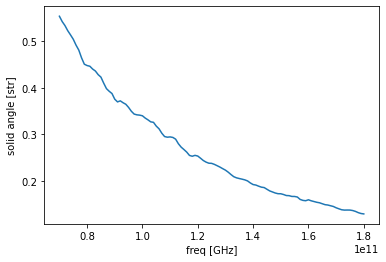

Text(0, 0.5, 'error(solid angle) [%]')

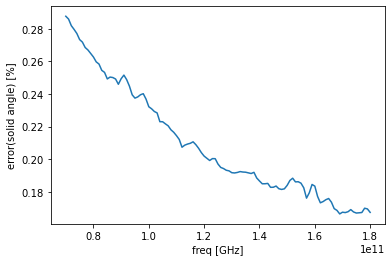

In [17]:
plt.plot(b.freqs, d.sas)
plt.xlabel('freq [GHz]')
plt.ylabel('solid angle [str]')
plt.show()

plt.plot(b.freqs, d.sas_err/d.sas*100)
plt.xlabel('freq [GHz]')
plt.ylabel('error(solid angle) [%]')

Then we also plot the "beam filling fraction" and its error. This is $\frac{\Omega_{d,cl}(v)}{\Omega_(v)}$:

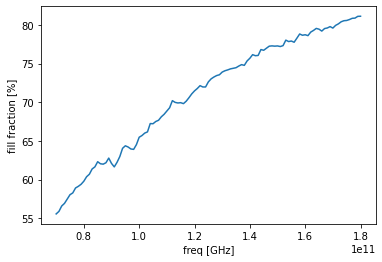

Text(0, 0.5, 'error(fill fraction) [%]')

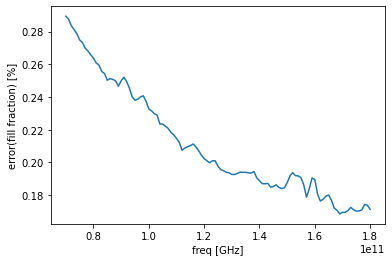

In [18]:
plt.plot(b.freqs, d.fill_fracs*100)
plt.xlabel('freq [GHz]')
plt.ylabel('fill fraction [%]')
plt.show()

plt.plot(b.freqs, d.fill_fracs_err/d.fill_fracs*100)
plt.xlabel('freq [GHz]')
plt.ylabel('error(fill fraction) [%]')

Let's add an on-wafer bandpass to this bolometer:

In [19]:
d1 = d.add_bandpass('MF-1')

We can plot all the terms in our power integral contributing to $f(v)$:

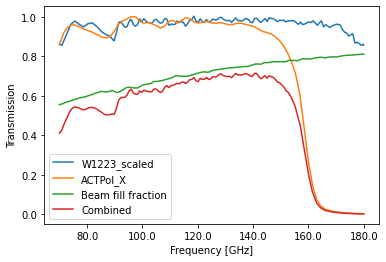

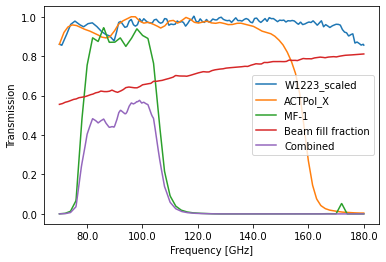

In [20]:
d.plot_spectra()
d1.plot_spectra()

We can examine this cool sanity check that graphically represents our angular integral:

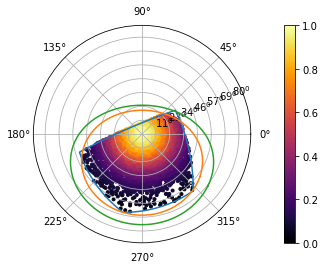

In [21]:
d1.plot_apertures()

Finally, we can use monte carlo integration to perform the integral over frequency!

In [22]:
Ts = np.linspace(.05, 10)
y, err_y = d.get_power(Ts, min = 72e9, max = 120e9)
y1, err_y1 = d1.get_power(Ts, min = 72e9, max = 120e9)

Plot the results:

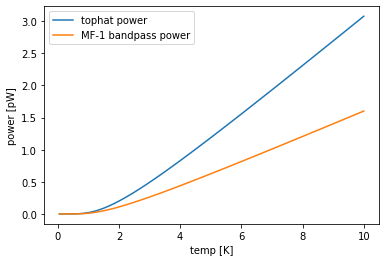

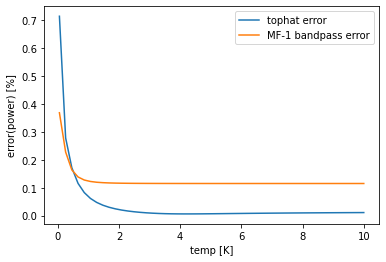

In [23]:
plt.plot(Ts, y/1e-12, label = 'tophat power')
plt.plot(Ts, y1/1e-12, label = 'MF-1 bandpass power')
plt.legend()
plt.xlabel('temp [K]')
plt.ylabel('power [pW]')
plt.show()

plt.plot(Ts, err_y/y*100, label = 'tophat error')
plt.plot(Ts, err_y1/y1*100, label = 'MF-1 bandpass error')
plt.xlabel('temp [K]')
plt.ylabel('error(power) [%]')
plt.legend()